In [2]:
import requests, pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import seaborn as sns  # opcional (solo para heatmap), puedes comentarlo si no quieres usar seaborn

# 👉 Reemplaza con TU URL RAW del JSON del proyecto anterior
api_url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"

OUTPUT_DIR = "telecomx_outputs"
FIG_DIR = f"{OUTPUT_DIR}/figures"
os.makedirs(FIG_DIR, exist_ok=True)
print("Fecha de ejecución:", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

Fecha de ejecución: 2025-08-20 05:47:01


In [4]:
data = requests.get("https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json").json()
df_raw = pd.json_normalize(data)
print("Filas x Columnas:", df_raw.shape)
df_raw.head()

Filas x Columnas: (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [5]:
df = df_raw.rename(columns={
    "customerID": "customer_id",
    "Churn": "churn",
    "customer.tenure": "tenure_months",
    "account.Charges.Monthly": "monthly_charges",
    "account.Charges.Total": "total_charges",
    "account.Contract": "contract_type",
    "account.PaymentMethod": "payment_method",
    "internet.InternetService": "internet_service",
    "internet.TechSupport": "tech_support",
    "internet.OnlineSecurity": "online_security",
    "internet.DeviceProtection": "device_protection",
    "internet.StreamingTV": "streaming_tv",
    "internet.StreamingMovies": "streaming_movies",
    "account.PaperlessBilling": "paperless_billing",
    "customer.SeniorCitizen": "senior_citizen",
    "customer.Dependents": "dependents",
    "customer.Partner": "partner"
})

# Tipos y limpieza
df["monthly_charges"] = pd.to_numeric(df["monthly_charges"], errors="coerce")
df["total_charges"] = pd.to_numeric(df["total_charges"], errors="coerce")
df["tenure_months"] = pd.to_numeric(df["tenure_months"], errors="coerce")
df["churn"] = df["churn"].map({"Yes":1, "No":0})

# Features derivadas
df["arpu"] = df["monthly_charges"]
df["clv_simple"] = df["arpu"] * np.clip(df["tenure_months"], 1, None)

print(df.shape)
df.head()

(7267, 23)


,customer_id,churn,customer.gender,senior_citizen,partner,dependents,tenure_months,phone.PhoneService,phone.MultipleLines,internet_service,...,tech_support,streaming_tv,streaming_movies,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,arpu,clv_simple
0,0002-ORFBO,0.0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,65.6,590.4
1,0003-MKNFE,0.0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,59.9,539.1
2,0004-TLHLJ,1.0,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,73.9,295.6
3,0011-IGKFF,1.0,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,98.0,1274.0
4,0013-EXCHZ,1.0,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,83.9,251.7


Clientes: 7267
Churn total: 0.2653698707936959


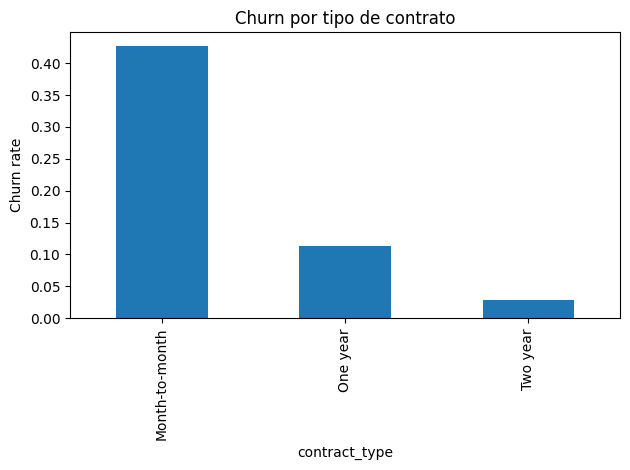

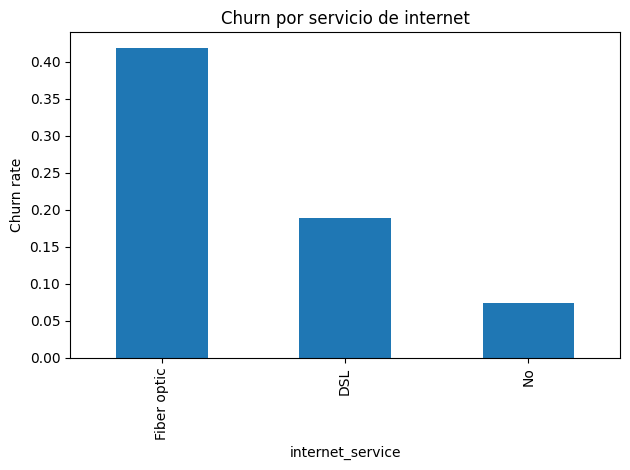

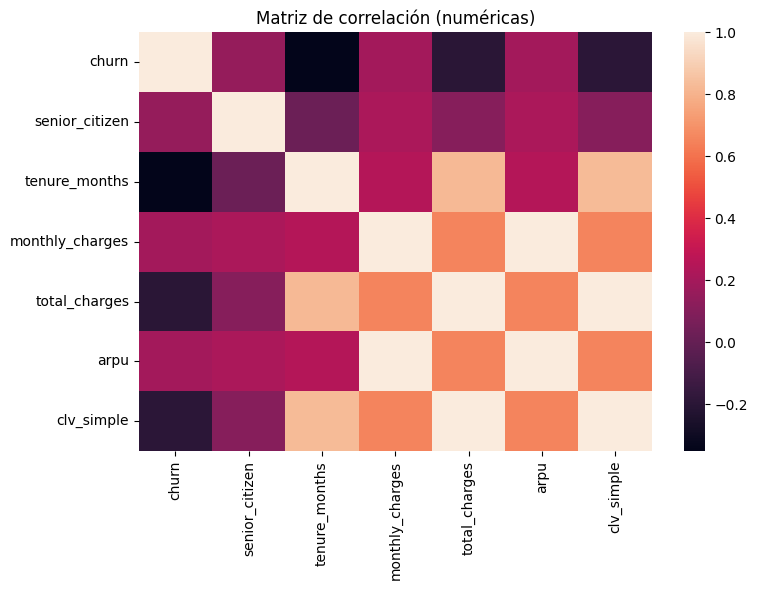

In [6]:
print("Clientes:", len(df))
print("Churn total:", df["churn"].mean())

# Churn por contrato
churn_by_contract = df.groupby("contract_type")["churn"].mean().sort_values(ascending=False)
churn_by_contract.plot(kind="bar")
plt.title("Churn por tipo de contrato")
plt.ylabel("Churn rate")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/churn_by_contract.png")
plt.show()

# Churn por internet
churn_by_internet = df.groupby("internet_service")["churn"].mean().sort_values(ascending=False)
churn_by_internet.plot(kind="bar")
plt.title("Churn por servicio de internet")
plt.ylabel("Churn rate")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/churn_by_internet.png")
plt.show()

# Correlaciones numéricas (si hay seaborn)
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()
try:
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=False)
    plt.title("Matriz de correlación (numéricas)")
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/corr_heatmap.png")
    plt.show()
except Exception as e:
    print("(Nota) Heatmap omitido:", e)


In [20]:
target = "churn"
drop_cols = ["customer_id"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns] + [target])
y = df[target]

# Drop rows where the target variable (y) is NaN
nan_rows = y.isna()
X = X[~nan_rows]
y = y[~nan_rows]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

num_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())])
cat_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore"))]) # Changed back to ignore

preprocess = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols),
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    "log_reg": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "random_forest": RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced_subsample"),
}

from sklearn.metrics import average_precision_score

def build_pipe(model):
    return Pipeline(steps=[("preprocess", preprocess), ("model", model)])

pipes = {name: build_pipe(m) for name, m in models.items()}
for name, p in pipes.items():
    p.fit(X_train, y_train)

def evaluate(pipe, X_te, y_te):
    y_prob = pipe.predict_proba(X_te)[:,1]
    y_pred = pipe.predict(X_te)
    return {
        "accuracy": accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred, zero_division=0),
        "recall": recall_score(y_te, y_pred, zero_division=0),
        "f1": f1_score(y_te, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_te, y_prob),
        "pr_auc": average_precision_score(y_te, y_prob)
    }, y_pred, y_prob

import pandas as pd
metrics = {}
for name, p in pipes.items():
    m, y_pred, y_prob = evaluate(p, X_test, y_test)
    metrics[name] = m
metrics_df = pd.DataFrame(metrics).T
metrics_df.round(4)

,accuracy,precision,recall,f1,roc_auc,pr_auc
log_reg,0.7402,0.5069,0.7861,0.6164,0.8433,0.6598
random_forest,0.7857,0.6295,0.4679,0.5368,0.8274,0.6272


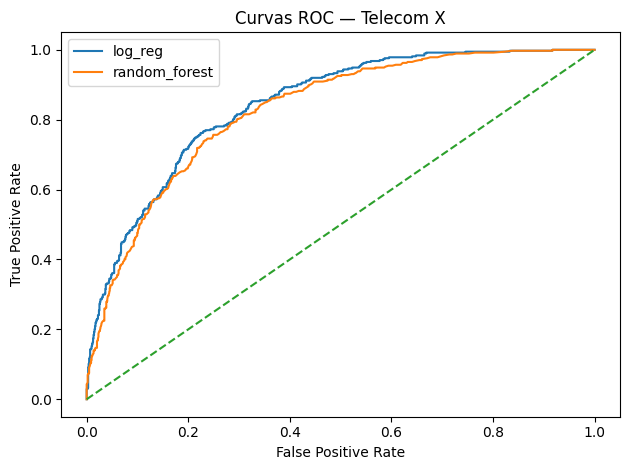

In [10]:
plt.figure()
for name, p in pipes.items():
    y_prob = p.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC — Telecom X")
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/roc_curves.png")
plt.show()

In [21]:
def get_feature_names(preprocessor: ColumnTransformer):
    """Gets the output feature names from a ColumnTransformer."""
    output_features = []
    for name, transformer, original_features in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            # For transformers that have get_feature_names_out (like OneHotEncoder)
            if name == 'cat':
                output_features.extend(transformer.get_feature_names_out(original_features))
            else:
                 output_features.extend(transformer.get_feature_names_out())
        # For transformers that don't have get_feature_names_out (like StandardScaler)
        elif isinstance(transformer, Pipeline):
             # Handle pipelines within the ColumnTransformer
            last_step = transformer.steps[-1][1]
            if hasattr(last_step, 'get_feature_names_out'):
                 output_features.extend(last_step.get_feature_names_out(original_features))
            else:
                output_features.extend(original_features) # Assume original names are kept
        else:
            # For simple transformers without get_feature_names_out
            output_features.extend(original_features)
    return output_features


feature_names = get_feature_names(pipes["random_forest"].named_steps["preprocess"])

# Coeficientes de la logística (datos estandarizados)
log_coefs = pipes["log_reg"].named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": log_coefs}).sort_values("coef", ascending=False)
coef_df.head(15)

,feature,coef
38,contract_type_Month-to-month,0.647003
18,internet_service_Fiber optic,0.575904
5,clv_simple,0.542705
45,payment_method_Electronic check,0.262544
34,streaming_tv_Yes,0.226554
29,tech_support_No,0.190394
37,streaming_movies_Yes,0.181542
20,online_security_No,0.149539
16,phone.MultipleLines_Yes,0.117428
42,paperless_billing_Yes,0.082019


In [31]:
from IPython.display import Markdown, display
best = metrics_df.sort_values("roc_auc", ascending=False).head(1)
winner = best.index[0]
md = f"""
# Conclusiones — Telecom X (Modelado inicial)

- **Mejor modelo (según ROC AUC)**: **{winner}**
{best.round(4).to_markdown()}

### Factores clave
- Coeficientes (LogReg) y *Permutation Importance* (RF) señalan impacto de: tipo de contrato (Month-to-month), medio de pago (Electronic check), tipo de internet (Fiber), cargos mensuales, antigüedad, interacción/llamadas.

### Recomendaciones iniciales
1. **Retención por contrato**: migrar clientes mes-a-mes a 1 año con incentivos temporales.
2. **Medios de pago**: promover TC/transferencia para clientes en Electronic check.
3. **Bundles y valor**: para usuarios Fiber, ofrecer paquetes que mejoren percepción de precio.
4. **Proactividad**: contactar clientes con alto ARPU y baja antigüedad / múltiples llamadas / inactivos >60 días.
"""
display(Markdown(md))


# Conclusiones — Telecom X (Modelado inicial)

- **Mejor modelo (según ROC AUC)**: **log_reg**  
|         |   accuracy |   precision |   recall |     f1 |   roc_auc |   pr_auc |
|:--------|-----------:|------------:|---------:|-------:|----------:|---------:|
| log_reg |     0.7402 |      0.5069 |   0.7861 | 0.6164 |    0.8433 |   0.6598 |

### Factores clave
- Coeficientes (LogReg) y *Permutation Importance* (RF) señalan impacto de: tipo de contrato (Month-to-month), medio de pago (Electronic check), tipo de internet (Fiber), cargos mensuales, antigüedad, interacción/llamadas.

### Recomendaciones iniciales
1. **Retención por contrato**: migrar clientes mes-a-mes a 1 año con incentivos temporales.
2. **Medios de pago**: promover TC/transferencia para clientes en Electronic check.
3. **Bundles y valor**: para usuarios Fiber, ofrecer paquetes que mejoren percepción de precio.
4. **Proactividad**: contactar clientes con alto ARPU y baja antigüedad / múltiples llamadas / inactivos >60 días.
